C:\Users\supri\AppData\Local\Temp\ipykernel_11472\902087230.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data[relevant_years] = cleaned_data[relevant_years].fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


KMeans Silhouette Score: 0.9001405009674617


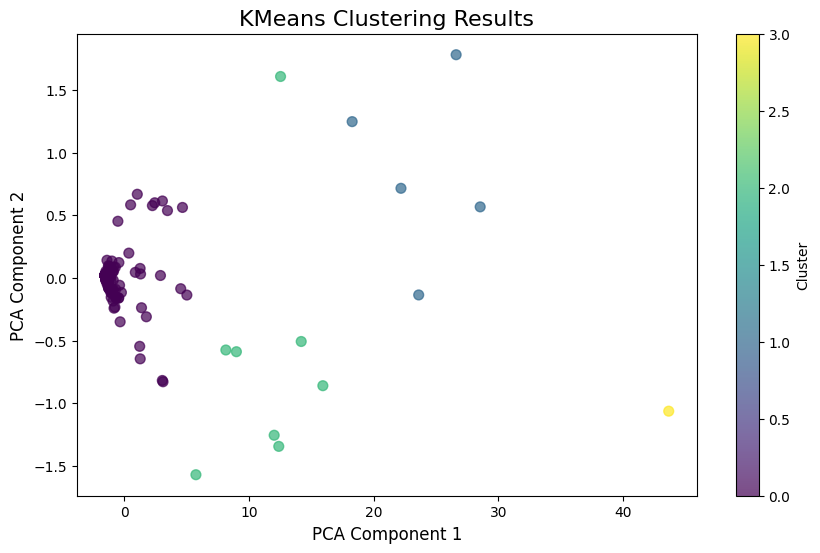

Countries similar to Thailand based on seasonal trends:
248     Ukraine
21     Bulgaria
201     Romania
148     Morocco
145      Latvia
Name: Country Name, dtype: object


C:\Users\supri\AppData\Local\Temp\ipykernel_11472\902087230.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_countries["Similarity"] = similarities


In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Load the cleaned dataset
file_path = "./data/API_ST.INT.ARVL_DS2_en_csv_v2_4420.csv"
data = pd.read_csv(file_path, skiprows=3)

# Filter for relevant years and drop unnecessary columns
relevant_years = [str(year) for year in range(1995, 2021)]
columns_to_keep = ["Country Name", "Country Code"] + relevant_years
cleaned_data = data[columns_to_keep]

# Drop rows where all relevant years are NaN
cleaned_data = cleaned_data.dropna(subset=relevant_years, how='all')

# Fill missing values using forward and backward filling
cleaned_data[relevant_years] = cleaned_data[relevant_years].fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(cleaned_data[relevant_years])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(normalized_data)
silhouette_avg = silhouette_score(normalized_data, kmeans_labels)
print(f"KMeans Silhouette Score: {silhouette_avg}")

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)

# Visualize the KMeans clustering
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('KMeans Clustering Results', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(label='Cluster')
plt.show()

# Build a recommendation function considering seasonal trends
def extract_seasonal_trends(data, years):
    """
    Extract seasonal trends by calculating the year-over-year difference in tourist arrivals.
    :param data: DataFrame with yearly tourist arrivals.
    :param years: List of years as columns.
    :return: DataFrame with seasonal trends.
    """
    seasonal_trends = data[years].diff(axis=1).fillna(0)
    return seasonal_trends

# Extract seasonal trends
seasonal_trends = extract_seasonal_trends(cleaned_data, relevant_years)
normalized_seasonal_trends = scaler.fit_transform(seasonal_trends)

# Update recommendation function
def recommend_similar_to(country_name, top_n=5):
    """
    Recommends countries similar to the selected country based on tourism patterns and seasonal trends.
    :param country_name: Name of the country for finding similar ones.
    :param top_n: Number of similar countries to recommend.
    :return: List of similar countries and their similarity scores.
    """
    # Find the cluster of the selected country
    country_index = cleaned_data[cleaned_data["Country Name"] == country_name].index[0]
    country_cluster = kmeans_labels[country_index]

    # Filter countries in the same cluster
    cluster_indices = np.where(kmeans_labels == country_cluster)[0]
    cluster_countries = cleaned_data.iloc[cluster_indices]
    cluster_seasonal_trends = normalized_seasonal_trends[cluster_indices]

    # Compute similarity as inverse Euclidean distance in seasonal trends
    selected_country_trend = normalized_seasonal_trends[country_index]
    similarities = np.linalg.norm(cluster_seasonal_trends - selected_country_trend, axis=1)

    # Add similarity scores to DataFrame
    cluster_countries["Similarity"] = similarities

    # Sort by similarity (ascending order, lower is more similar)
    similar_countries = cluster_countries.sort_values("Similarity")["Country Name"]
    return similar_countries.head(top_n)

# Example: Recommend top 5 countries similar to Thailand considering seasonal trends
recommendations = recommend_similar_to(country_name="Thailand", top_n=5)
print("Countries similar to Thailand based on seasonal trends:")
print(recommendations)
